In [1]:
from pyNBS import data_import_tools as dit
from pyNBS import network_propagation as prop
from pyNBS import pyNBS_core as core
from pyNBS import pyNBS_single
from pyNBS import consensus_clustering as cc
from pyNBS import pyNBS_plotting as plot
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
import time
import networkx as nx
import pandas as pd
import numpy as np
from IPython.display import Image

## Running Parameters

|Param|Help|
|:------|:------|
|verbose|Verbosity flag for reporting on patient similarity network construction steps.|
|sm_data_file|Path to binary mutation matrix file. May be a csv or 2-column list where each line is a sample and the gene mutated separated by a common delimiter.|
|network_path|Path to molecular network file. File must be table where each line is a gene interaction separated by a common delimiter and the first 2 columns represent interacting proteins.|
|mut_filetype|File structure of binary mutation data. 2 options: "matrix" (e.g. csv or tsv) or "list" (2-column list). Typically reading a "list" is faster.|
|mut_filedelim|Delimiter used in binary mutation file. Default is tab white space.|
|net_filedelim|Delimiter used in network file between columns. Default is tab white space.|
|degree_preserved_shuffle|Determination of whether or not to shuffle the network edges (while preserving node degree) when loading network.|
|node_label_shuffle|Determination of whether or not to shuffle the network node labels (while preserving network topology) when loading network.|
|regularize_network|Determination of whether or not to calculate influence matrix regularization network for regularized NMF step.|
|reg_net_gamma|Value of adjustment on propagation network graph laplacian to calculate influence matrix for (via Vandin 2011).|
|k_nearest_neighbors|Number of nearest neighbors to add to the regularization network during construction.|
|save_knn_glap|File path of where to save graph laplacian for k-nearest-neighbor network constructed from propagation network influence matrix. No path given as default, automatically saves pandas hdf file if file path given.|
|regularization_network_graph_laplacian_file|Path to regularization network graph laplacian matrix if previously calculated. Required if 'regularize_network' is False.|
|niter|Number of iterations to perform sub-sampling and network-regularized NMF before consensus clustering.|
|calculate_propagation_kernel|Determination of whether or not to pre-calculate network kernel for network propagation. Highly recommended if no network kernel file is given already and niter > 10.|
|propagation_kernel_file|Path to pre-calculated propagation kernel of network. This will save time in the propagation step.|
|save_H|File path of where to save decomposed patient profiles. No path given as default, automatically saves csv file if file path given.|
|consensus_cluster|Determination of whether or not to perform consensus clustering on decompositions of patient profiles.|
|assign_clusters|Determination of whether or not to assign numerical clusters to patients based on consensus clustering of patient profiles.|
|save_co_cluster_matrix|File path of where to save patient co-clustering matrix. No path given as default, automatically saves csv file if file path given.|
|save_cluster_assignments|File path of where to save patient cluster assignments. No path given as default, automatically saves csv file if file path given.|
|plot_co_cluster_map|Determination of whether or not to plot the co-clustering matrix. Requires consensus clustering and cluster assignments.|
|plot_title|Title of co-clustering matrix map if desired.|
|save_co_cluster_map|File path of where to save co-clustering matrix plot. No path given as default, automatically saves pdf file if file path given.|




In [4]:
run_pyNBS_params = {'verbose' : True,
                    
                    ##### Path for Uterine #####
                    # Data used in this notebook is located in /data folder in the repository.
                    # To run this notebook, please modify the path to indicate your local directory.
                    # If you would like to use your own data file, 
                    # please refer to the "Load data" cell below for formatting details.
                                     
                    'sm_data_file' : '/cellar/users/t1jia/pyNBS/data/UCEC_sm_mat_labelled.csv',
                    'network_path' : '/cellar/users/t1jia/pyNBS/data/ST90.sif',
                    
                     # Please make sure you modify file path for loading/saving to indicate your local directory
                    'mut_filetype' : 'matrix',
                    'mut_filedelim' : ',',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,
                    
                    'regularize_network' : True, #**
                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    
                    'save_knn_glap' : '/cellar/users/t1jia/Data/UCEC_notebook_results_1000x250/knnglap.hdf', #**
                    'regularization_network_graph_laplacian_file' : None,
                    
                    'niter' : 1000, 
                    'calculate_propagation_kernel' : True,
                    
                    'propagation_kernel_file' : None,
                    'save_kernel' : '/cellar/users/t1jia/Data/UCEC_notebook_results_1000x250/kernel.hdf', #**
                    'save_H' : '/cellar/users/t1jia/Data/UCEC_notebook_results_1000x250/H/', #**
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '/cellar/users/t1jia/Data/UCEC_notebook_results_1000x250/UT_co_cluster_matrix.csv', #**
                    'save_cluster_assignments' : '/cellar/users/t1jia/Data/UCEC_notebook_results_1000x250/UT_cluster_assignment.csv', #**
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'Uterine Consensus Cluster Map',
                    'save_co_cluster_map' : '/cellar/users/t1jia/Data/UCEC_notebook_results_1000x250/UT_co_cluster_.png'
                    }

## NBS Options

|Option|Type|Default|Help|
|:------|:------|:------|:------|
|pats_subsample_p|float|0.8|Proportion of samples to sub-sample|
|gene_subsample_p|float|0.8|Proportion of mutated genes to sub-sample|
|min_muts|positive_int|10|Minimum number of mutations for a sample to contain after sub-sampling to be considered for further analysis|
|prop_data|bool|True|Determination of whether or not to propagate sub-sampled binary mutation data over given molecular network 
|prop_alpha  |restricted_float|0.7|Propagation constant to use in the propagation of mutations over molecular network. Range is 0.0-1.0 exclusive. |
|prop_symmetric_norm|bool|False|Network degree normalization method for random walk-propagation. |
|qnorm_data  |bool  |True |Determination of whether or not to qunatile normalize mutation profiles. |
|netNMF_k  |positive_int  |4 |Number of components to decompose patient mutation data into. Same as the number of clusters of patients to separate data into. |
|netNMF_gamma  |positive_int  |200 |Regularization constant to scale network regularization term in netNMF. |
|netNMF_update_gamma |bool |False |Determination of whether or not to constantly update regularization constant based on balance between reconstruction error and regularization term.|
|netNMF_gamma_factor |positive_int |1 |Scaling factor for regularization constant updates if 'netNMF_update_gamma' is True. |
|netNMF_niter  |positive_int  |250 |Maximum umber of multiplicative updates to perform within network-regularized NMF if result does not converge. |
|netNMF_eps  |float  |1e-15  |Epsilon error value to adjust 0 values during multiplicative matrix updates in netNMF |
|netNMF_err_tol  |float  |1e-4  |Minimum error tolerance for matrix reconstruction of original data for convergence. |
|netNMF_err_delta_tol  |float  |1e-4  |Minimum error tolerance for l2 norm of difference in matrix reconstructions between iterations of netNMF for convergence. |

In [5]:
NBS_options = {'pats_subsample_p' : 0.8, 
               'gene_subsample_p' : 0.8, 
               'min_muts' : 10,
               'prop_data' : True, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : True, # Use symetic norm for Uterine task
               'qnorm_data' : True,
               'netNMF_k' : 3, 
               'netNMF_gamma' : 200, 
               'netNMF_update_gamma' : False, 
               'netNMF_gamma_factor' : 1,
               'netNMF_niter' : 250, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}


## Load data

Somatic mutation data and network are __required__ to run pyNBS. 
>__Somatic mutation data__ can be of two filetypes: __matrix__ or __list__
>>A __matrix__ is a binary csv or tsv matrix with rows represent samples/patients and columns represent genes. <br>
Following table is an example of the somatic mutation data format:

||A1CF|A2BP1|A2M|
|-|-|-|-|
|TCGA-04-1638|0|0|1|
|TCGA-23-1029|1|0|0|
|TCGA-23-2647|0|1|0|
|TCGA-24-1847|0|0|1|
|TCGA-42-2589|1|0|0|


>> A __list__ is a 2 column text file separeated by delimeter where 1st column is sample/patient, 2nd column is one gene mutated in that patient. 
The following chart is an example of a list file:

|Patient ID|Gene mutated|
|-|-|
|TCGA-04-1638|A2M|
|TCGA-23-1029|A1CF|
|TCGA-23-2647|A2BP1|
|TCGA-24-1847|A2M|
|TCGA-42-2589|A1CF|
>__Network file__ is a unweighted network. The default delimiter is tab, yet it can be set by user. Only the first two colcumns are read as edges for the network, all other columns will be ignored. There are also options to shuffle the network by preserving node-degree or by permuting network node labels


In [6]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/UCEC_sm_mat_labelled.csv
Network File Loaded: /cellar/users/t1jia/pyNBS/data/ST90.sif


## knnGlap 

Construct or load the pre-constructed KNN regularization network graph laplacian. <br> __Parameters and options:__ <br>

|Parameter|Name in run_pyNBS_params|Default value|Description|
|:-|:-|:-|:-|
|$\gamma$|reg_net_gamma|0.01|The diagnal correction value suggested in Vandin 2011*|
|$k_n$|k_nearest_neighbors|11|The number of nearest neighbors to construct network regularizer from|

__Steps to construct knnGlap:__
> 1. Construct network laplacian matrix
> 2. Adjust diagonal of laplacian matrix by small gamma as seen in Vandin 2011*
> 3. Calculate the inverse of diagonal adjusted graph laplacian to get graph influence matrix (Vandin 2011*) <br> _This method is significantly faster than the method proposed previously in NBS v0.2.0 to calculate the pseudoinverse of each network component._
> 4. Construct KNN graph using the 11 nearest neighbors by influence score
> 5. Save to the given path

---
* Fabio Vandin, Eli Upfal, and Benjamin J. Raphael. Journal of Computational Biology. March 2011, 18(3): 507-522. https://doi.org/10.1089/cmb.2010.0265

In [7]:
# Get knnGlap
if run_pyNBS_params['regularize_network']:
    knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])
else:
    # Load propatagion kernel
    if run_pyNBS_params['regularization_network_graph_laplacian_file'].endswith('.hdf'):
        knnGlap = pd.read_hdf(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    else:
        knnGlap = pd.read_csv(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated regularization network graph laplacian loaded'


Graph influence matrix calculated: 94.1720190048 seconds


/cellar/users/t1jia/anaconda2/lib/python2.7/site-packages/pandas/io/pytables.py:268: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->axis0] [items->None]

  f(store)
/cellar/users/t1jia/anaconda2/lib/python2.7/site-packages/pandas/io/pytables.py:268: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->axis1] [items->None]

  f(store)


Graph laplacian of KNN network from influence matrix calculated: 149.077044964 seconds


/cellar/users/t1jia/anaconda2/lib/python2.7/site-packages/pandas/io/pytables.py:268: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block0_items] [items->None]

  f(store)


## Network propagation kernel

Construct or load the pre-constructed network propagation kernel.<br>
Implementation is based on the closed form of the random walk model over networks presented by the HotNet2 paper.<br>

__Parameters and options: __

|Parameters/Option|Name in run_pyNBS_params|Default|Description|Note|
|:-|:-|:-|:-|:-|
|$$\alpha$$|prop_alpha|0.7|Propagation constant to use in the propagation of mutations over molecular network. Range is 0.0-1.0 exclusive.|0.7 is used in Hofree paper; further tunning can be done for potentially better result|
|symmetric_norm|prop_symmetric_norm|False|Network degree normalization method for random walk-propagation|Symetric norm is used in the uterine task|

__Steps for network propagation:__
> 1. Separate network into connected components and calculate propagation values of each sub-sample on each connected component
> 2. Random walk propagation on all sub-graphs.<br>
Closed form random-walk propagation for each subgraph is given by: <br>
$$F_t = (1-\alpha)*F_o*(I-\alpha*A)^{-1}$$<br>
Let A be the adjcency matrix, D be the diagonalized degree sum of adjacency matrix A. <br>If symmetric norm is used, then the adjacency matrix is normalized as $D^{-0.5} * A * D^{-0.5}$; Otherwise the network is normalized as $A*D^{-1}$

> 3. Return propagation result as dataframe


In [8]:
# Get network propagation kernel
if run_pyNBS_params['propagation_kernel_file'] is not None:
    # Load propagation kernel
    if run_pyNBS_params['propagation_kernel_file'].endswith('.hdf'):
        kernel = pd.read_hdf(run_pyNBS_params['propagation_kernel_file'])
    else:
        kernel = pd.read_csv(run_pyNBS_params['propagation_kernel_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated network kernel loaded'
else:
    if run_pyNBS_params['calculate_propagation_kernel']:
        # Calculate propagation kernel by propagating identity matrix of network
        network_nodes = network.nodes()
        network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
        kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_kernel'])  
        if run_pyNBS_params['verbose']:
            print 'Network kernel calculated'
    else:
        kernel = None
        if run_pyNBS_params['verbose']:
            print 'No network kernel established'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 395.323332071 seconds
Network kernel calculated


## Sub-sampling and netNMF decomposition

__Parameters and options: __

|Parameters/Option|Default|Description|
|:-|:-|:-|
|niter|1000|Number of iterations to perform sub-sampling and network-regularized NMF before consensus clustering|
|pats_subsample_p|0.8|Proportion of samples to sub-sample|
|gene_subsample_p|0.8|Proportion of mutated genes to sub-sample|
|min_muts|10|Minimum number of mutations for a sample to contain after sub-sampling to be considered for further analysis|
|prop_data|True|Determination of whether or not to propagate sub-sampled binary mutation data over given molecular network 
|prop_alpha  |0.7|Propagation constant to use in the propagation of mutations over molecular network. Range is 0.0-1.0 exclusive. |
|prop_symmetric_norm|False|Network degree normalization method for random walk-propagation. |
|qnorm_data  |True |Determination of whether or not to qunatile normalize mutation profiles. |
|netNMF_k  |4 |Number of components to decompose patient mutation data into. Same as the number of clusters of patients to separate data into. |
|netNMF_gamma  |200 |Regularization constant to scale network regularization term in netNMF. |
|netNMF_update_gamma |False |Determination of whether or not to constantly update regularization constant based on balance between reconstruction error and regularization term.|
|netNMF_gamma_factor |1 |Scaling factor for regularization constant updates if 'netNMF_update_gamma' is True. |
|netNMF_niter  |250 |Maximum umber of multiplicative updates to perform within network-regularized NMF if result does not converge. |
|netNMF_eps  |1e-15  |Epsilon error value to adjust 0 values during multiplicative matrix updates in netNMF |
|netNMF_err_tol  |1e-4  |Minimum error tolerance for matrix reconstruction of original data for convergence. |
|netNMF_err_delta_tol  |1e-4  |Minimum error tolerance for l2 norm of difference in matrix reconstructions between iterations of netNMF for convergence. |

__Steps for Sub-sampling and netNMF decomposition__
> __Subsampling__
  1. Sub-sample binary somatic mutation profile based on _pats_subsample_p_ and _gene_subsample_p_;
  2. Filter min mutation based on _min_muts_;
  3. Filter columns by network nodes if a network is provided
  
> __Propagate data (Optional but recommanded)__
  1. If no kernel is provided, use closed form of the random walk model over full network by subgraphs (HotNet2)
  2. If a pre-calculated kernel is provided, propagate binary mutation matrix over network by subgraph. Pre-calcuated kernel saves a significant amount of time for many runs of NBS
  
> __Quantile normalization (Optional)__
  1. Sort each patient by gene propagation value
  2. Rank averages for each gene across samples
  3. Assign ranked averages to ranks of each gene for each sample
  
> __netNMF decomposition__
  1. In each iternation, update W and H with network constrains
  2. Track reconstruction errors and residuals



In [9]:
%%time
Hlist = []
time_list = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']+repr(i+1)))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        time_list.append(t)
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'
np.savetxt('/cellar/users/t1jia/Data/UCEC_notebook_results_1000x250/NBS_iteration_time.csv',time_list)


NBS iteration: 1 complete: 99.2981078625 seconds
NBS iteration: 2 complete: 100.718109846 seconds
NBS iteration: 3 complete: 101.162509918 seconds
NBS iteration: 4 complete: 98.1819329262 seconds
NBS iteration: 5 complete: 95.1556549072 seconds
NBS iteration: 6 complete: 99.1273050308 seconds
NBS iteration: 7 complete: 99.0257101059 seconds
NBS iteration: 8 complete: 99.9057080746 seconds
NBS iteration: 9 complete: 96.7828781605 seconds
NBS iteration: 10 complete: 97.4821798801 seconds
NBS iteration: 11 complete: 97.3814702034 seconds
NBS iteration: 12 complete: 97.6132941246 seconds
NBS iteration: 13 complete: 94.9967360497 seconds
NBS iteration: 14 complete: 95.337141037 seconds
NBS iteration: 15 complete: 95.0946638584 seconds
NBS iteration: 16 complete: 98.1673769951 seconds
NBS iteration: 17 complete: 92.4443750381 seconds
NBS iteration: 18 complete: 98.6483490467 seconds
NBS iteration: 19 complete: 95.4593360424 seconds
NBS iteration: 20 complete: 94.1009631157 seconds
NBS iterat

NBS iteration: 165 complete: 99.612226963 seconds
NBS iteration: 166 complete: 96.0227742195 seconds
NBS iteration: 167 complete: 95.7826960087 seconds
NBS iteration: 168 complete: 94.5897190571 seconds
NBS iteration: 169 complete: 99.4043271542 seconds
NBS iteration: 170 complete: 96.0627000332 seconds
NBS iteration: 171 complete: 90.5812621117 seconds
NBS iteration: 172 complete: 92.5147650242 seconds
NBS iteration: 173 complete: 93.3359179497 seconds
NBS iteration: 174 complete: 90.5922088623 seconds
NBS iteration: 175 complete: 94.052875042 seconds
NBS iteration: 176 complete: 96.7641470432 seconds
NBS iteration: 177 complete: 99.215572834 seconds
NBS iteration: 178 complete: 92.4856798649 seconds
NBS iteration: 179 complete: 94.6062071323 seconds
NBS iteration: 180 complete: 96.2939801216 seconds
NBS iteration: 181 complete: 98.6691291332 seconds
NBS iteration: 182 complete: 97.2760510445 seconds
NBS iteration: 183 complete: 98.2894349098 seconds
NBS iteration: 184 complete: 100.9

NBS iteration: 327 complete: 99.863765955 seconds
NBS iteration: 328 complete: 98.5144071579 seconds
NBS iteration: 329 complete: 95.0872089863 seconds
NBS iteration: 330 complete: 91.714949131 seconds
NBS iteration: 331 complete: 101.259114027 seconds
NBS iteration: 332 complete: 93.1226549149 seconds
NBS iteration: 333 complete: 96.0098459721 seconds
NBS iteration: 334 complete: 100.327430964 seconds
NBS iteration: 335 complete: 100.921523094 seconds
NBS iteration: 336 complete: 97.6569430828 seconds
NBS iteration: 337 complete: 91.8528950214 seconds
NBS iteration: 338 complete: 95.085570097 seconds
NBS iteration: 339 complete: 88.3211889267 seconds
NBS iteration: 340 complete: 93.8543109894 seconds
NBS iteration: 341 complete: 90.6856799126 seconds
NBS iteration: 342 complete: 95.3969240189 seconds
NBS iteration: 343 complete: 100.733608007 seconds
NBS iteration: 344 complete: 99.1308629513 seconds
NBS iteration: 345 complete: 99.3024561405 seconds
NBS iteration: 346 complete: 98.43

NBS iteration: 489 complete: 95.4824271202 seconds
NBS iteration: 490 complete: 95.4265589714 seconds
NBS iteration: 491 complete: 99.6037390232 seconds
NBS iteration: 492 complete: 98.2829139233 seconds
NBS iteration: 493 complete: 94.5635421276 seconds
NBS iteration: 494 complete: 101.377433062 seconds
NBS iteration: 495 complete: 96.6833209991 seconds
NBS iteration: 496 complete: 96.2106509209 seconds
NBS iteration: 497 complete: 97.0984280109 seconds
NBS iteration: 498 complete: 91.7423419952 seconds
NBS iteration: 499 complete: 97.0808830261 seconds
NBS iteration: 500 complete: 99.3644449711 seconds
NBS iteration: 501 complete: 103.676880121 seconds
NBS iteration: 502 complete: 91.4711010456 seconds
NBS iteration: 503 complete: 95.8142359257 seconds
NBS iteration: 504 complete: 92.4040689468 seconds
NBS iteration: 505 complete: 96.8816349506 seconds
NBS iteration: 506 complete: 98.9298269749 seconds
NBS iteration: 507 complete: 93.0381360054 seconds
NBS iteration: 508 complete: 97

NBS iteration: 650 complete: 94.7794599533 seconds
NBS iteration: 651 complete: 96.5328359604 seconds
NBS iteration: 652 complete: 98.7747159004 seconds
NBS iteration: 653 complete: 97.218667984 seconds
NBS iteration: 654 complete: 87.6428968906 seconds
NBS iteration: 655 complete: 96.5065522194 seconds
NBS iteration: 656 complete: 100.236065865 seconds
NBS iteration: 657 complete: 92.8659980297 seconds
NBS iteration: 658 complete: 91.3245520592 seconds
NBS iteration: 659 complete: 96.6827039719 seconds
NBS iteration: 660 complete: 97.5339360237 seconds
NBS iteration: 661 complete: 94.1367208958 seconds
NBS iteration: 662 complete: 97.4772500992 seconds
NBS iteration: 663 complete: 98.998529911 seconds
NBS iteration: 664 complete: 92.8392710686 seconds
NBS iteration: 665 complete: 99.234899044 seconds
NBS iteration: 666 complete: 96.782255888 seconds
NBS iteration: 667 complete: 92.7896959782 seconds
NBS iteration: 668 complete: 97.2582199574 seconds
NBS iteration: 669 complete: 99.337

NBS iteration: 811 complete: 98.0232379436 seconds
NBS iteration: 812 complete: 94.8251800537 seconds
NBS iteration: 813 complete: 94.1918511391 seconds
NBS iteration: 814 complete: 99.7414088249 seconds
NBS iteration: 815 complete: 105.882017851 seconds
NBS iteration: 816 complete: 97.6073980331 seconds
NBS iteration: 817 complete: 98.6850790977 seconds
NBS iteration: 818 complete: 98.916189909 seconds
NBS iteration: 819 complete: 84.990678072 seconds
NBS iteration: 820 complete: 97.1048259735 seconds
NBS iteration: 821 complete: 99.0331318378 seconds
NBS iteration: 822 complete: 91.9493701458 seconds
NBS iteration: 823 complete: 91.1641750336 seconds
NBS iteration: 824 complete: 98.8384039402 seconds
NBS iteration: 825 complete: 98.6217460632 seconds
NBS iteration: 826 complete: 99.8081240654 seconds
NBS iteration: 827 complete: 98.7240889072 seconds
NBS iteration: 828 complete: 94.5550558567 seconds
NBS iteration: 829 complete: 98.6353840828 seconds
NBS iteration: 830 complete: 77.9

NBS iteration: 973 complete: 104.552576065 seconds
NBS iteration: 974 complete: 98.8230080605 seconds
NBS iteration: 975 complete: 97.685999155 seconds
NBS iteration: 976 complete: 99.535474062 seconds
NBS iteration: 977 complete: 95.0447180271 seconds
NBS iteration: 978 complete: 99.3158209324 seconds
NBS iteration: 979 complete: 93.4658391476 seconds
NBS iteration: 980 complete: 98.0751149654 seconds
NBS iteration: 981 complete: 98.491904974 seconds
NBS iteration: 982 complete: 89.0546789169 seconds
NBS iteration: 983 complete: 99.0188210011 seconds
NBS iteration: 984 complete: 92.6749560833 seconds
NBS iteration: 985 complete: 100.664017916 seconds
NBS iteration: 986 complete: 96.8528590202 seconds
NBS iteration: 987 complete: 100.43679595 seconds
NBS iteration: 988 complete: 100.398910046 seconds
NBS iteration: 989 complete: 98.4200909138 seconds
NBS iteration: 990 complete: 98.6500580311 seconds
NBS iteration: 991 complete: 96.9534649849 seconds
NBS iteration: 992 complete: 94.750

## Consensus Clustering

> __Steps for consensus clustering__
1. Takes a list of 'H' (patient-by-k) dataframes and performs 'hard' consensus clustering
2. Using hierarchical clustering and average linkage
3. Returns similarity table (distance is 1-similarity) and linkage map of patients
4. Also returns cluster assignment map of patients if wanted

In [10]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'


Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [11]:
#Cluster assignments
ori_assin_table = pd.read_table('/cellar/users/t1jia/pyNBS/Hofree_NBS_paper_results/Paper_UCEC_NBS_Results.csv',sep=',',index_col=0)
ref_assign_table = pd.read_table('/cellar/users/t1jia/pyNBS/data/UCEC_clusters.csv',sep=',',index_col=0)
cluster_assign = pd.concat([ori_assin_table.iloc[:,0], NBS_cluster_assign,ref_assign_table.iloc[:,2]], axis=1).dropna(axis=0,how='any').astype(int)
ori_paper_cluster_assign = cluster_assign.iloc[:,0]
NBS_cluster_assign = cluster_assign.iloc[:,1].astype(int)


In [12]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    ori_paper_cluster_assign_cmap = plot.cluster_color_assign(ori_paper_cluster_assign, name='Original Paper Cluster Assignment')

    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=ori_paper_cluster_assign_cmap, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

/cellar/users/t1jia/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Consensus Clustering map saved


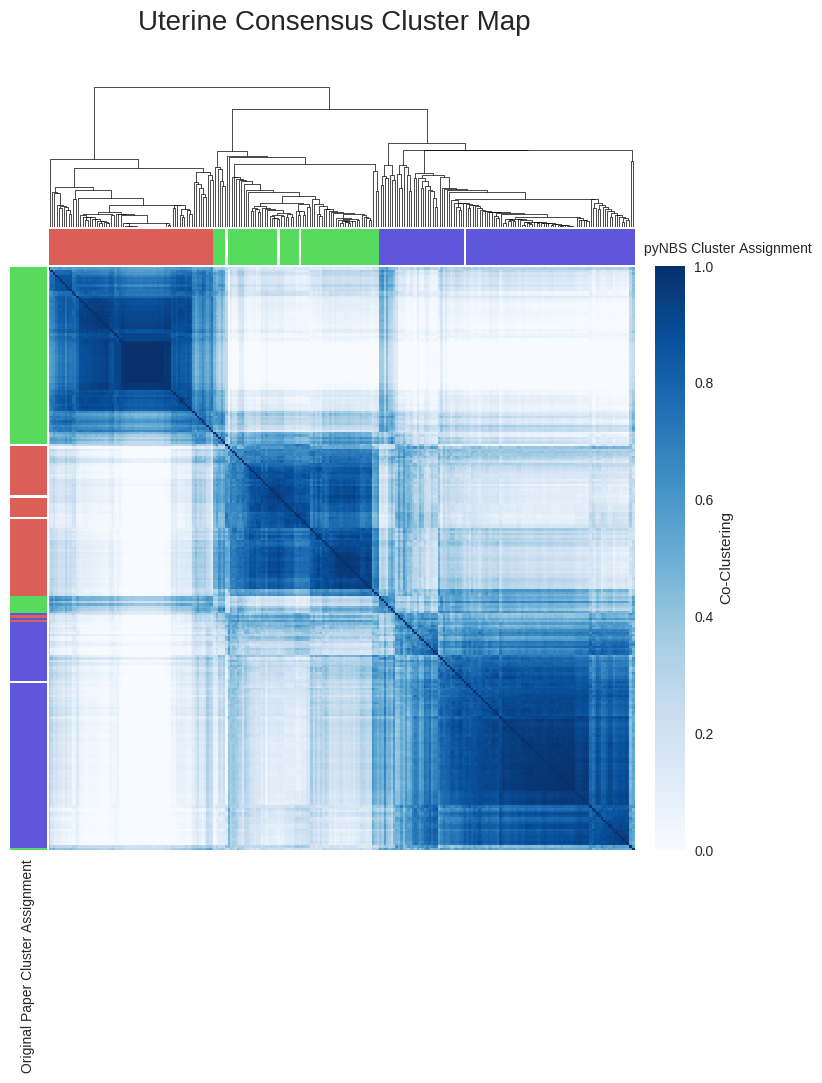

In [13]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

## Result Compare to the Orignal Paper

__Adjusted Rand Index (ARI)__
> Rand index adjusted for chance.
$$ARI = \frac{RI - \mathbb{E}(RI)}{ \max(RI) - \mathbb{E}(RI)}$$

__Adjusted Mutual Info Score (AMI)__
> Adjusted Mutual Information between two clusterings.
$${AMI(U, V) = \frac{MI(U, V) - \mathbb{E}(MI(U, V))}{\max(H(U), H(V)) - \mathbb{E}(MI(U, V))}}$$


In [14]:
adj_rand_index = adjusted_rand_score(ori_paper_cluster_assign,NBS_cluster_assign)
adj_mutual_info_score = adjusted_mutual_info_score(ori_paper_cluster_assign,NBS_cluster_assign)
if run_pyNBS_params['verbose']:
    print 'Adjusted Rand Index is: ' + str(adj_rand_index)
    print 'Adjusted Mutual Info Score is: ' + str(adj_mutual_info_score)

Adjusted Rand Index is: 0.822780726174
Adjusted Mutual Info Score is: 0.786718877695
